In [1]:
import pandas as pd
from time import sleep # control the crawl rate to avoid hammering the servers with too many requests
from random import randint
from tqdm import tqdm
import re
import datetime

from scrapping import scrapping_foundation_features

In [ ]:
############# need to get the date of the first review in this dataset as well #######################

In [2]:
list_of_foundations_url = pd.read_csv('foundation_from_sephora_with_url.csv')
list_of_foundations_url = list_of_foundations_url[list_of_foundations_url['url_valid'] == 1].reset_index(drop=True)

In [23]:
for i in tqdm(range(144, len(list_of_foundations_url))):
    features = scrapping_foundation_features(url = list_of_foundations_url.loc[i, 'url'], product_name=list_of_foundations_url.loc[i, 'brand_product'])
    features.set_up_driver()
    features.scrap_product_description_and_features()
    features.save_data_to_json()
    # features.push_data_to_gsc()
    features.close_driver()

100%|██████████| 15/15 [02:14<00:00,  8.98s/it]


### Engineering Foundation Features

In [418]:
# to get the list of foundations from directory
import os
list_of_foundation_names = []
for file in os.listdir('data_foundation_features/'):
   if file.endswith(".json"):
      list_of_foundation_names.append(os.path.join(file))

In [419]:
list_of_foundation_names = sorted(list_of_foundation_names)

In [420]:
len(list_of_foundation_names)

160

In [421]:
list_of_models = sorted([i+'_features.json' for i in os.listdir('models/')])[1:]

In [422]:
len(list_of_models) # I only trained models with foundations having more than 200 reviews

88

In [423]:
all_foundations = pd.concat([
    pd.read_json(f'data_foundation_features/{list_of_models[i]}', lines=True) for i in range(len(list_of_models))
]).reset_index(drop=True)

In [424]:
all_foundations.columns

Index(['brand_product', 'product_features', 'product_description'], dtype='object')

In [425]:
len(all_foundations)

88

In [426]:
all_foundations['product_features'] = all_foundations['product_features'].str.lower()
all_foundations['product_description'] = all_foundations['product_description'].str.lower()

In [427]:
type(all_foundations.loc[0, 'product_features'])

float

In [428]:
list_of_foundations_to_drop = []
skin_types = ['dry', 'oily', 'combo', 'combination', 'normal']
for skin_type in skin_types:
    for i in tqdm(range(len(all_foundations))):
        if type(all_foundations.loc[i, 'product_features']) == str:
            if re.findall(f'.+{skin_type}.+', all_foundations.loc[i,'product_features']) != []:
                all_foundations.loc[i, f'skin_type_{skin_type}'] = 1
        if type(all_foundations.loc[i, 'product_description']) == str:
            if re.findall(f'{skin_type}', all_foundations.loc[i,'product_description']) != []:
                all_foundations.loc[i, f'skin_type_{skin_type}'] = 1
        if type(all_foundations.loc[i, 'product_features']) != str:
            if type(all_foundations.loc[i, 'product_description']) != str:
                list_of_foundations_to_drop.append(i)
    all_foundations[f'skin_type_{skin_type}'].fillna(0, inplace=True)
# all_foundations = all_foundations.drop(all_foundations.index[list_of_foundations_to_drop]).reset_index(drop=True)

100%|██████████| 88/88 [00:00<00:00, 10401.84it/s]


In [429]:
all_foundations.head()

,brand_product,product_features,product_description,skin_type_dry,skin_type_oily,skin_type_combo,skin_type_combination,skin_type_normal
0,Anastasia_Beverly_Hills_Stick_Foundation,NaN,item 1852409\nskin type:\n✔ combination\n✔ oil...,0.0,1.0,0.0,1.0,0.0
1,Armani_Beauty_Neo_Nude_Foundation,natural finish\nlight coverage\nhyaluronic aci...,item 2355691\nwhat it is: a skincare-infused l...,1.0,1.0,1.0,1.0,1.0
2,Armani_Beauty_Power_Fabric_Longwear_High_Cover...,matte finish\nfull coverage\nlong-wearing\nall...,item 1919505\nwhat it is: a liquid foundation ...,1.0,1.0,0.0,1.0,1.0
3,Bite_Beauty_Changemaker_Supercharged_Micellar_...,long-wearing\nlight coverage\nliquid formula\n...,item 2253193\nonly at sephora\nwhat it is: a c...,1.0,1.0,0.0,1.0,1.0
4,Bobbi_Brown_Skin_Foundation_SPF_15,liquid formula\nlight coverage\nnatural finish...,item 1288448\ncoverage:\n✔ medium\n\nskin type...,1.0,1.0,1.0,1.0,1.0


In [432]:
all_foundations.loc[1, 'product_features']

'natural finish\nlight coverage\nhyaluronic acid\nhydrating\nwithout parabens\nbest for dry, combo, normal skin'

In [436]:
sum(all_foundations['skin_type_normal']) / len(all_foundations)

0.6931818181818182

<AxesSubplot:xlabel='skin_type_normal', ylabel='count'>

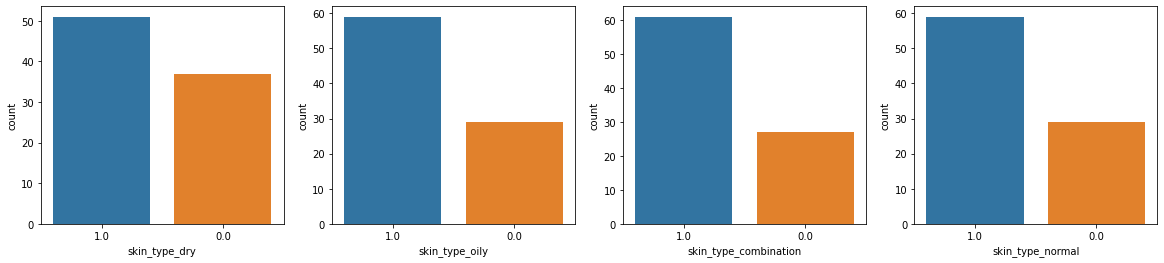

In [439]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
sns.countplot(x=all_foundations['skin_type_dry'], order=all_foundations['skin_type_dry'].value_counts().index, ax=ax1)
# ax1.set_xlabel('Self-reported skin tones')
# ax1.set_ylabel('Number of people')
# ax1.title.set_text('26% of the reviewers self-report to have light skin tones')
# ax1.tick_params(axis='x', rotation=45)

sns.countplot(x=all_foundations['skin_type_oily'], order=all_foundations['skin_type_oily'].value_counts().index, ax=ax2)
# ax2.set_xlabel('Self-reported hair colors')
# ax2.set_ylabel('Number of people')
# ax2.tick_params(axis='x', rotation=45)
# ax2.title.set_text('49% say they are brunettes')

sns.countplot(x=all_foundations['skin_type_combination'], order=all_foundations['skin_type_combination'].value_counts().index, ax=ax3)
# ax3.set_xlabel('Self-reported eye colors')
# ax3.set_ylabel('Number of people')
# ax3.tick_params(axis='x', rotation=45)
# ax3.title.set_text('55% say they have brown eyes')

sns.countplot(x=all_foundations['skin_type_normal'], order=all_foundations['skin_type_normal'].value_counts().index, ax=ax4)

In [447]:
re.findall(f'finish\: natural', all_foundations.loc[4, 'product_description'])

[]

In [452]:
# finish
list_of_foundations_to_drop = []
finishes = ['natural', 'matte', 'radiant']
for finish in finishes:
    for i in tqdm(range(len(all_foundations))):
        if type(all_foundations.loc[i, 'product_features']) == str:
            if re.findall(f'{finish}', all_foundations.loc[i,'product_features']) != []:
                all_foundations.loc[i, f'{finish}_finish'] = 1
        if type(all_foundations.loc[i, 'product_description']) == str:
            if re.findall(f'finish\: {finish}', all_foundations.loc[i,'product_description']) != []:
                all_foundations.loc[i, f'{finish}_finish'] = 1
        if type(all_foundations.loc[i, 'product_features']) != str:
            if type(all_foundations.loc[i, 'product_description']) != str:
                list_of_foundations_to_drop.append(i)
    all_foundations[f'{finish}_finish'].fillna(0, inplace=True)


100%|██████████| 88/88 [00:00<00:00, 5855.36it/s]


In [453]:
all_foundations.head()

,brand_product,product_features,product_description,skin_type_dry,skin_type_oily,skin_type_combo,skin_type_combination,skin_type_normal,natural_finish,matte_finish,radiant_finish
0,Anastasia_Beverly_Hills_Stick_Foundation,NaN,item 1852409\nskin type:\n✔ combination\n✔ oil...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Armani_Beauty_Neo_Nude_Foundation,natural finish\nlight coverage\nhyaluronic aci...,item 2355691\nwhat it is: a skincare-infused l...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,Armani_Beauty_Power_Fabric_Longwear_High_Cover...,matte finish\nfull coverage\nlong-wearing\nall...,item 1919505\nwhat it is: a liquid foundation ...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0
3,Bite_Beauty_Changemaker_Supercharged_Micellar_...,long-wearing\nlight coverage\nliquid formula\n...,item 2253193\nonly at sephora\nwhat it is: a c...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0
4,Bobbi_Brown_Skin_Foundation_SPF_15,liquid formula\nlight coverage\nnatural finish...,item 1288448\ncoverage:\n✔ medium\n\nskin type...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


<AxesSubplot:xlabel='radiant_finish', ylabel='count'>

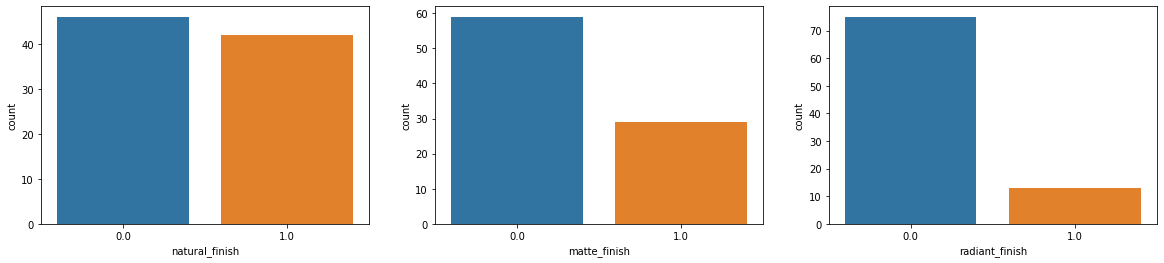

In [454]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
sns.countplot(x=all_foundations['natural_finish'], order=all_foundations['natural_finish'].value_counts().index, ax=ax1)
# ax1.set_xlabel('Self-reported skin tones')
# ax1.set_ylabel('Number of people')
# ax1.title.set_text('26% of the reviewers self-report to have light skin tones')
# ax1.tick_params(axis='x', rotation=45)

sns.countplot(x=all_foundations['matte_finish'], order=all_foundations['matte_finish'].value_counts().index, ax=ax2)
# ax2.set_xlabel('Self-reported hair colors')
# ax2.set_ylabel('Number of people')
# ax2.tick_params(axis='x', rotation=45)
# ax2.title.set_text('49% say they are brunettes')

sns.countplot(x=all_foundations['radiant_finish'], order=all_foundations['radiant_finish'].value_counts().index, ax=ax3)
# ax3.set_xlabel('Self-reported eye colors')
# ax3.set_ylabel('Number of people')
# ax3.tick_params(axis='x', rotation=45)
# ax3.title.set_text('55% say they have brown eyes')

In [469]:
# coverage
list_of_foundations_to_drop = []
coverages = ['medium', 'full', 'sheer', 'light']
for coverage in coverages:
    for i in tqdm(range(len(all_foundations))):
        if type(all_foundations.loc[i, 'product_features']) == str:
            if re.findall(f'{coverage} coverage', all_foundations.loc[i,'product_features']) != []:
                all_foundations.loc[i, f'{coverage}_coverage'] = 1
        if type(all_foundations.loc[i, 'product_description']) == str:
            if re.findall(f'coverage\: {coverage}', all_foundations.loc[i,'product_description']) != []:
                all_foundations.loc[i, f'{coverage}_coverage'] = 1
            elif re.findall(f'.+{coverage}.+', all_foundations.loc[i,'product_description']) != []:
                all_foundations.loc[i, f'{coverage}_coverage'] = 1
        if type(all_foundations.loc[i, 'product_features']) != str:
            if type(all_foundations.loc[i, 'product_description']) != str:
                list_of_foundations_to_drop.append(i)
    all_foundations[f'{coverage}_coverage'].fillna(0, inplace=True)

100%|██████████| 88/88 [00:00<00:00, 4632.09it/s]


In [470]:
all_foundations

,brand_product,product_features,product_description,skin_type_dry,skin_type_oily,skin_type_combo,skin_type_combination,skin_type_normal,natural_finish,matte_finish,radiant_finish,medium_coverage,full_coverage,sheer_coverage,light_coverage
0,Anastasia_Beverly_Hills_Stick_Foundation,NaN,item 1852409\nskin type:\n✔ combination\n✔ oil...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,Armani_Beauty_Neo_Nude_Foundation,natural finish\nlight coverage\nhyaluronic aci...,item 2355691\nwhat it is: a skincare-infused l...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,Armani_Beauty_Power_Fabric_Longwear_High_Cover...,matte finish\nfull coverage\nlong-wearing\nall...,item 1919505\nwhat it is: a liquid foundation ...,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0
3,Bite_Beauty_Changemaker_Supercharged_Micellar_...,long-wearing\nlight coverage\nliquid formula\n...,item 2253193\nonly at sephora\nwhat it is: a c...,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0
4,Bobbi_Brown_Skin_Foundation_SPF_15,liquid formula\nlight coverage\nnatural finish...,item 1288448\ncoverage:\n✔ medium\n\nskin type...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,tarte_Amazonian_Clay_BB_Tinted_Moisturizer_Bro...,NaN,item 759779\nskin type:\n✔ normal\n✔ combinati...,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
84,tarte_Amazonian_Clay_Full_Coverage_Airbrush_Fo...,NaN,item 1534650\n\n\nskin type:\n✔ normal\n✔ comb...,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
85,tarte_BB_Tinted_Treatment_12-Hour_Primer_Broad...,spf\nvegan\nmedium coverage\nmatte finish\nlon...,item 2413045\ncoverage:\n✔ medium\n\nskin type...,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0
86,tarte_Clay_Stick_Foundation,NaN,item 1952746\ncoverage:\n✔ medium\n\nskin type...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<AxesSubplot:xlabel='light_coverage', ylabel='count'>

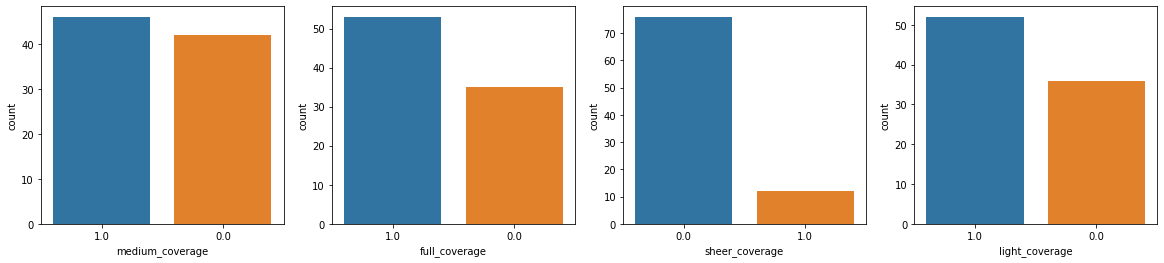

In [471]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 4))
sns.countplot(x=all_foundations['medium_coverage'], order=all_foundations['medium_coverage'].value_counts().index, ax=ax1)
# ax1.set_xlabel('Self-reported skin tones')
# ax1.set_ylabel('Number of people')
# ax1.title.set_text('26% of the reviewers self-report to have light skin tones')
# ax1.tick_params(axis='x', rotation=45)

sns.countplot(x=all_foundations['full_coverage'], order=all_foundations['full_coverage'].value_counts().index, ax=ax2)
# ax2.set_xlabel('Self-reported hair colors')
# ax2.set_ylabel('Number of people')
# ax2.tick_params(axis='x', rotation=45)
# ax2.title.set_text('49% say they are brunettes')

sns.countplot(x=all_foundations['sheer_coverage'], order=all_foundations['sheer_coverage'].value_counts().index, ax=ax3)
# ax3.set_xlabel('Self-reported eye colors')
# ax3.set_ylabel('Number of people')
# ax3.tick_params(axis='x', rotation=45)
# ax3.title.set_text('55% say they have brown eyes')

sns.countplot(x=all_foundations['light_coverage'], order=all_foundations['light_coverage'].value_counts().index, ax=ax4)

In [472]:
all_foundations.to_csv("foundation_features_parsed.csv", index=False)